#                                                                    Project code

In [1]:
# Load of libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
df=pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.shape

(918, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df.drop_duplicates()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [6]:
continuos_f = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
categorical_f = ["ChestPainType", "RestingECG", "ST_Slope"]
binaries_f = ["Sex", "FastingBS", "ExerciseAngina"]

In [7]:
df.isna().all()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

In [8]:
df[continuos_f].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


<Figure size 576x396 with 0 Axes>

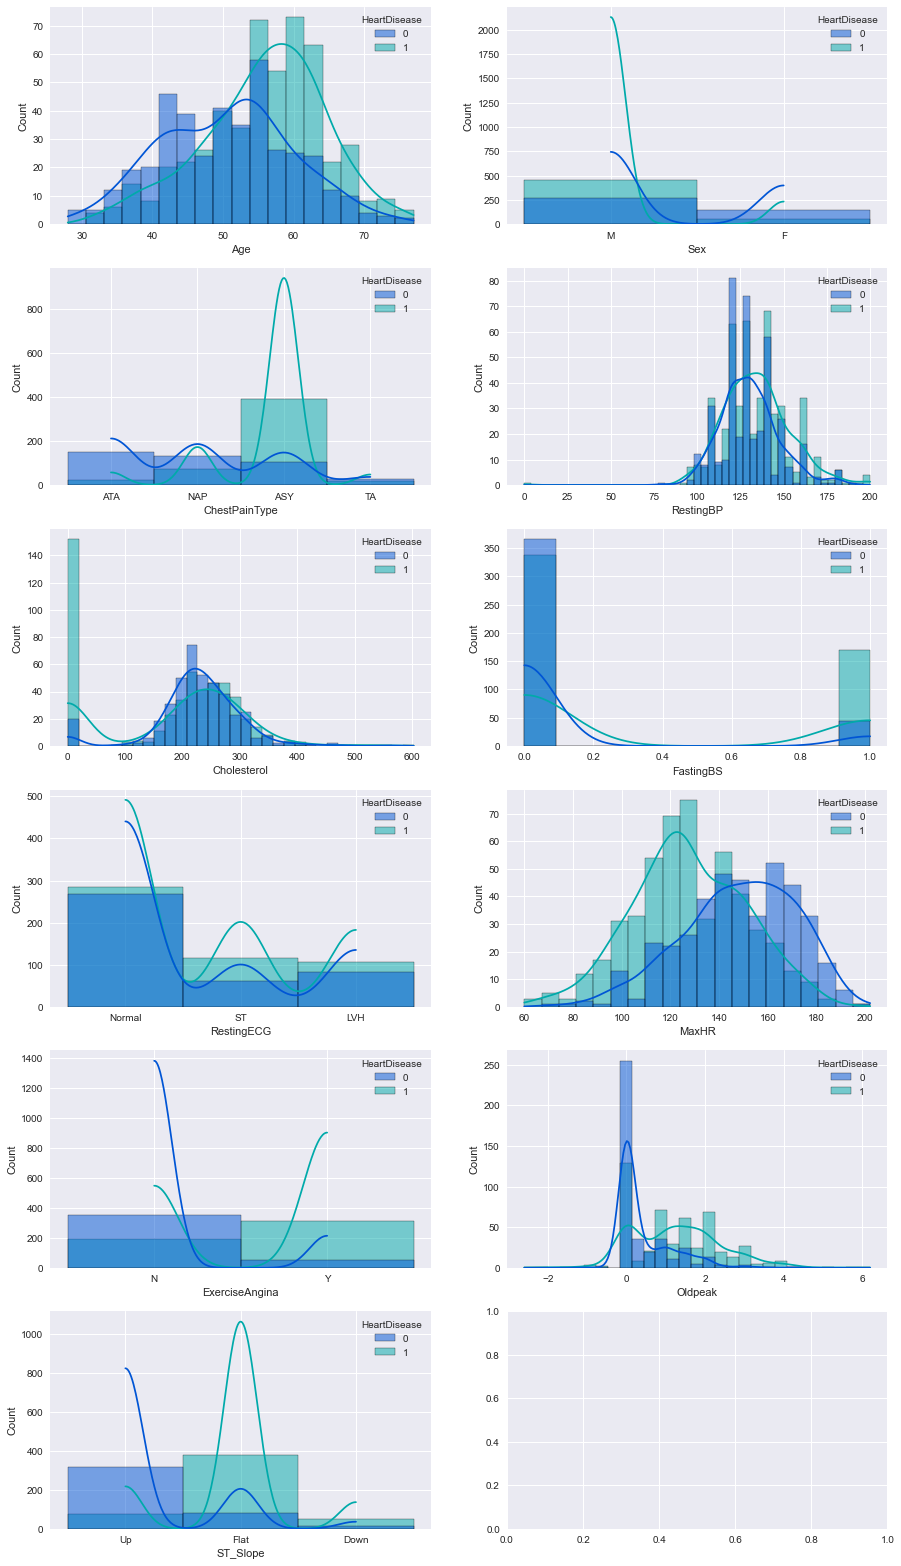

In [9]:
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.2)
color = 'winter'

fig, axs = plt.subplots(6, 2, figsize=(15,28))
i=1
for feature in df.columns:
    if feature not in ["HeartDisease"] and i < 14:
        plt.subplot(6,2,i)
        sns.histplot(data=df, x=feature, kde=True, palette=color, hue='HeartDisease')
        i+=1

# Outlier Detection
We have previously seen that features like cholesterol and resting blood pressure present atypical cases, this cases not represent the condition of general population and this data type we don't useful to train our model of predictions, let's see how to treat them:

In [10]:
def detect_outliers(label=None):
    Q1 = df[label].quantile(0.25)
    Q3 = df[label].quantile(0.75)
    IQR = Q3 - Q1
    interval = ((df[label] > Q1 - 1.5*IQR) & (df[label] < Q3 + 1.5*IQR))
    return df[interval], df[~interval]

def assign_mean(df_out, not_df_out, label=None):
    df.loc[df_out[df_out["HeartDisease"] == 0].index, label] = not_df_out[not_df_out["HeartDisease"] == 0][label].mean()
    df.loc[df_out[df_out["HeartDisease"] == 1].index, label] = not_df_out[not_df_out["HeartDisease"] == 1][label].mean()
    return

def delete_outliers(df_out):
    return df.drop(df_out.index)

# Cholesterol

<AxesSubplot:xlabel='Cholesterol'>

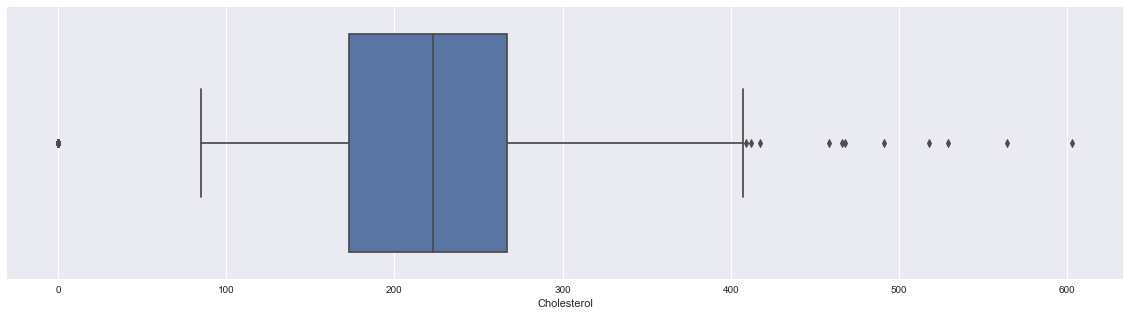

In [11]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="Cholesterol")

In [12]:
not_df_out_ch, df_out_ch = detect_outliers('Cholesterol')
print(f'Outliers in cholesterol represent the {round((df_out_ch.shape[0]*100)/df.shape[0], 2)}% of our dataset')
df_out_ch

Outliers in cholesterol represent the 19.93% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
28,53,F,ATA,113,468,0,Normal,127,N,0.0,Up,0
30,53,M,NAP,145,518,0,Normal,130,N,0.0,Flat,1
69,44,M,ASY,150,412,0,Normal,170,N,0.0,Up,0
76,32,M,ASY,118,529,0,Normal,130,N,0.0,Flat,1
103,40,M,ASY,120,466,1,Normal,152,Y,1.0,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1
536,62,M,NAP,133,0,1,ST,119,Y,1.2,Flat,1
616,67,F,NAP,115,564,0,LVH,160,N,1.6,Flat,0
667,65,F,NAP,140,417,1,LVH,157,N,0.8,Up,0


These outliers represent the 19.93% of our dataset. There are registers with zero values these are human errors, the best solution consist is to deleted them while the rest of the register will be assigned the mean cholesterol of the data set.

<AxesSubplot:xlabel='Cholesterol', ylabel='Count'>

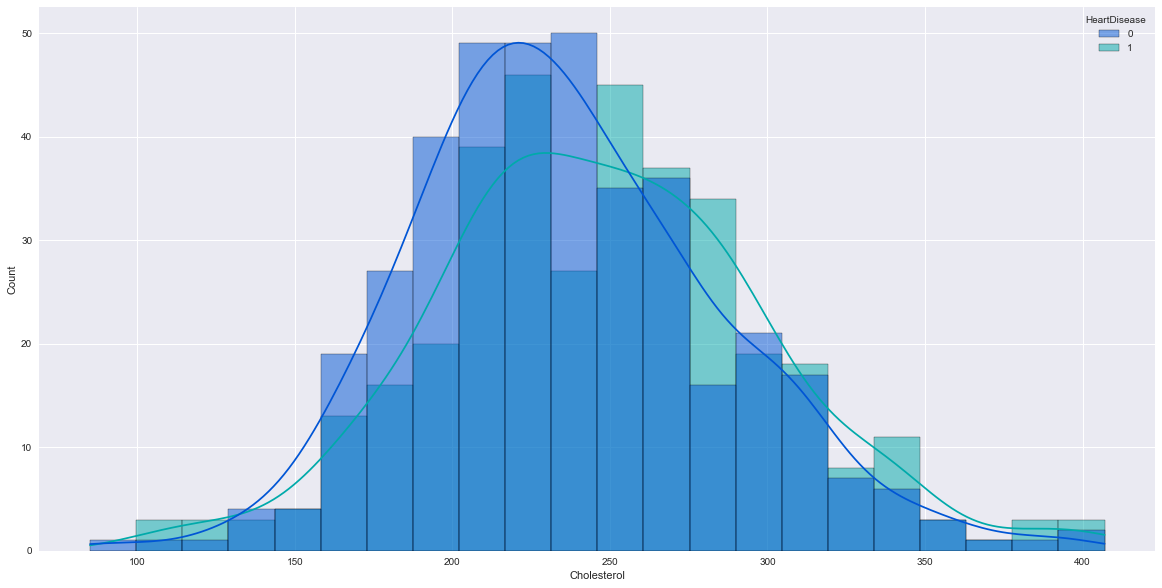

In [13]:
df = delete_outliers(df_out_ch[df_out_ch["Cholesterol"] == 0])
assign_mean(df_out_ch[df_out_ch["Cholesterol"] != 0], not_df_out_ch, 'Cholesterol')

plt.figure(figsize=(20,10))
sns.histplot(data=df, x='Cholesterol', kde=True, palette=color, hue='HeartDisease')

# Resting Blood Pressure

<AxesSubplot:xlabel='RestingBP'>

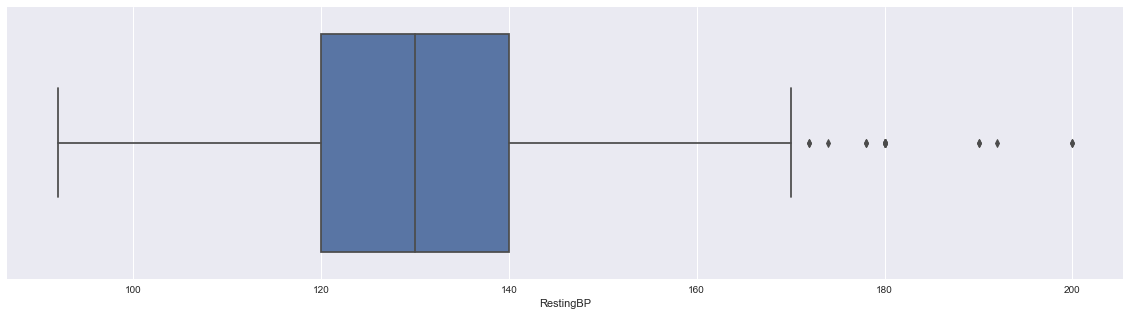

In [14]:
plt.figure(figsize=(20,5))
sns.boxplot(data=df, x="RestingBP")

In [15]:
not_df_out_rbp, df_out_rbp = detect_outliers('RestingBP')
print(f'Outliers in resting blood pressure represent the {round((df_out_rbp.shape[0]*100)/df.shape[0], 2)}% of our dataset')
df_out_rbp

Outliers in resting blood pressure represent the 4.29% of our dataset


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
86,65,M,ASY,170,263.0,1,Normal,112,Y,2.0,Flat,1
109,39,M,ATA,190,241.0,0,Normal,106,N,0.0,Up,0
123,58,F,ATA,180,393.0,0,Normal,110,Y,1.0,Flat,1
132,56,M,ASY,170,388.0,0,ST,122,Y,2.0,Flat,1
189,53,M,ASY,180,285.0,0,ST,120,Y,1.5,Flat,1
190,46,M,ASY,180,280.0,0,ST,120,N,0.0,Up,0
191,50,M,ATA,170,209.0,0,ST,116,N,0.0,Up,0
215,30,F,TA,170,237.0,0,ST,170,N,0.0,Up,0
241,54,M,ASY,200,198.0,0,Normal,142,Y,2.0,Flat,1
274,45,F,ATA,180,295.0,0,Normal,180,N,0.0,Up,0


In this case the outliers in resting blood pressure represent the 4.58% of total cases, we can delete them.

<AxesSubplot:xlabel='RestingBP', ylabel='Count'>

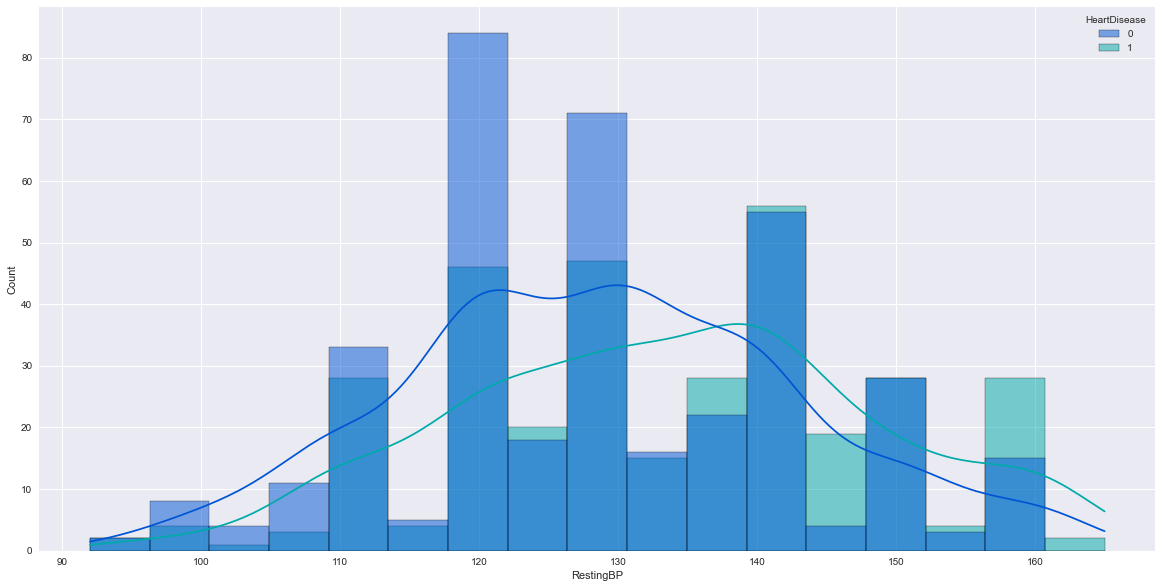

In [16]:
df = delete_outliers(df_out_rbp)
plt.figure(figsize=(20,10))
sns.histplot(data=df, x='RestingBP', kde=True, palette=color, hue='HeartDisease')

# Features encoding

In [17]:
#Binary features enconding
df["Sex"] = df["Sex"].map({'M':1, 'F':0})
df["ExerciseAngina"] = df["ExerciseAngina"].map({'N':0, 'Y':1})
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289.0,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180.0,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283.0,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214.0,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195.0,0,Normal,122,0,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,TA,110,264.0,0,Normal,132,0,1.2,Flat,1
914,68,1,ASY,144,193.0,1,Normal,141,0,3.4,Flat,1
915,57,1,ASY,130,131.0,0,Normal,115,1,1.2,Flat,1
916,57,0,ATA,130,236.0,0,LVH,174,0,0.0,Flat,1


# Data Binning

In [18]:
df_bin = df.copy()
for feature in continuos_f:
    bins = 5
    df_bin[feature] = pd.cut(df[feature], bins=bins, labels=range(bins)).astype(np.int64)
df_bin

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,1,1,ATA,3,3,0,Normal,3,0,0,Up,0
1,2,0,NAP,4,1,0,Normal,3,0,0,Flat,1
2,0,1,ATA,2,3,0,ST,1,0,0,Up,0
3,2,0,ASY,3,2,0,Normal,1,1,1,Flat,1
4,2,1,NAP,3,1,0,Normal,1,0,0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,1,TA,1,2,0,Normal,2,0,1,Flat,1
914,4,1,ASY,3,1,1,Normal,2,0,2,Flat,1
915,2,1,ASY,2,0,0,Normal,1,1,1,Flat,1
916,2,0,ATA,2,2,0,LVH,3,0,0,Flat,1


In [19]:
# One-hot encoding
df_dumm = pd.get_dummies(df_bin, columns = categorical_f+continuos_f)
df_dumm

,Sex,FastingBS,ExerciseAngina,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,...,MaxHR_0,MaxHR_1,MaxHR_2,MaxHR_3,MaxHR_4,Oldpeak_0,Oldpeak_1,Oldpeak_2,Oldpeak_3,Oldpeak_4
0,1,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,0,0,1,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,1,0,0,1,0,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
914,1,1,0,1,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
915,1,0,1,1,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
916,0,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


# Correlations between features and label:

<AxesSubplot:>

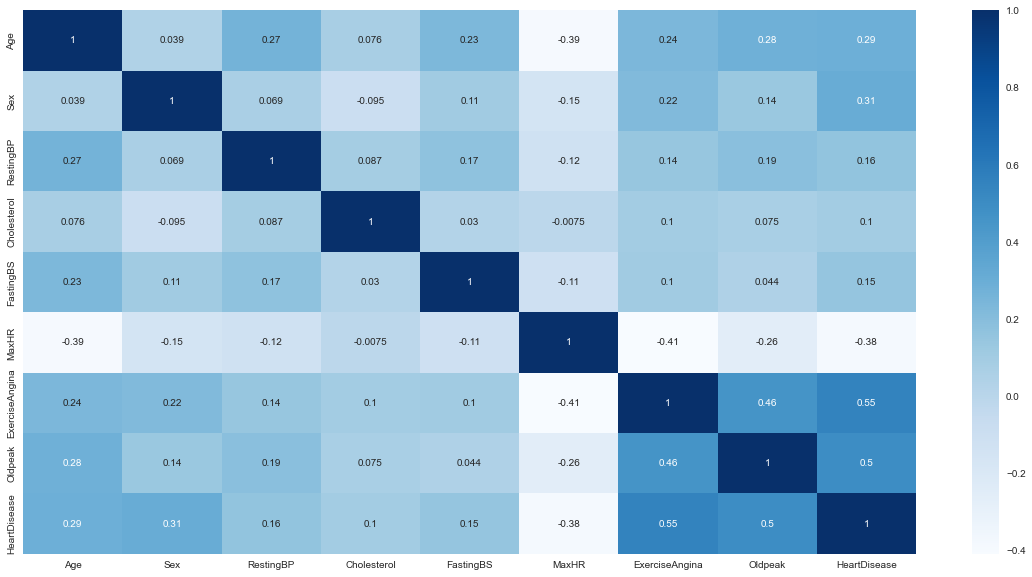

In [20]:
corr=df.corr()
plt.figure(figsize=(20,10)) 
sns.heatmap(corr,cmap="Blues",annot=True)

In [21]:
df_corr = df_dumm.corr()
df_corr["HeartDisease"].sort_values(ascending=False)

HeartDisease         1.000000
ST_Slope_Flat        0.595251
ExerciseAngina       0.548979
ChestPainType_ASY    0.523843
Sex                  0.306487
Oldpeak_1            0.297261
Oldpeak_2            0.261787
MaxHR_1              0.246226
Age_3                0.234047
FastingBS            0.148923
Oldpeak_3            0.126768
ST_Slope_Down        0.122051
RestingBP_4          0.110814
Cholesterol_3        0.108742
RestingBP_3          0.108064
MaxHR_0              0.102105
RestingECG_ST        0.099583
MaxHR_2              0.083049
Age_4                0.077150
Oldpeak_4            0.069091
RestingECG_LVH       0.063949
Cholesterol_0        0.010481
Cholesterol_4        0.009348
Cholesterol_2       -0.007519
RestingBP_2         -0.030745
Age_2               -0.037033
ChestPainType_TA    -0.042540
RestingBP_0         -0.074276
Cholesterol_1       -0.093403
RestingBP_1         -0.115718
RestingECG_Normal   -0.130259
Age_0               -0.135895
Age_1               -0.166444
MaxHR_4   

# Division into training and test sets

In [22]:
df_clean = df_dumm.copy()

X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train

,Sex,FastingBS,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,...,MaxHR_0,MaxHR_1,MaxHR_2,MaxHR_3,MaxHR_4,Oldpeak_0,Oldpeak_1,Oldpeak_2,Oldpeak_3,Oldpeak_4
222,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
680,1,0,1,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
114,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
637,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
792,1,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,1,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
100,1,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
94,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
26,1,0,1,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [23]:
X_test

,Sex,FastingBS,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,...,MaxHR_0,MaxHR_1,MaxHR_2,MaxHR_3,MaxHR_4,Oldpeak_0,Oldpeak_1,Oldpeak_2,Oldpeak_3,Oldpeak_4
13,1,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
771,1,0,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
220,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
795,1,1,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
537,1,1,1,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,0
473,1,1,1,0,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
693,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
77,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [24]:
logreg = LogisticRegression(max_iter=900)
# fit the model on the training data
logreg.fit(X_train, y_train)
# make predictions on the testing data
y_pred = logreg.predict(X_test)
# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9230769230769231


In [25]:
model = RandomForestClassifier(n_estimators=100)

# train the model using the training data
model.fit(X_train, y_train)

# test the model using the testing data
accuracy = model.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.916083916083916


In [26]:
dt_classifier = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the Decision Tree Classifier on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_classifier.predict(X_test)

# Calculate the accuracy of the Decision Tree Classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8951048951048951


In [27]:
metric = 'recall'

In [28]:
cv = 15
nFeatures = len(X_train.columns)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1]) 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Poisitive Rate")
    
def print_scores(y, y_pred):
    ac, pr, rc, f1 = accuracy_score(y, y_pred)*100, precision_score(y, y_pred)*100, recall_score(y, y_pred)*100, f1_score(y, y_pred, average='weighted')*100
    print(f"Accuracy:{ac}")
    print(f"Precision:{pr}")
    print(f"Recall:{rc}")
    print(f"F1-score:{f1}")
    return {'ac': ac, 'pr':pr, 'rc':rc, 'f1':f1}

# K-Nearest Neighbors Classifier

In [29]:
param_grid = [{
    'n_neighbors':np.arange(5, 21),
    'weights':['uniform', 'distance'],
    'p':[1, 2],
}]

knn_clf = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_clf, param_grid, cv=cv, scoring=metric)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                          'p': [1, 2], 'weights': ['uniform', 'distance']}],
             scoring='recall')

In [30]:
best_knn_clf = grid_knn.best_estimator_
grid_knn.best_params_

{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}

<AxesSubplot:>

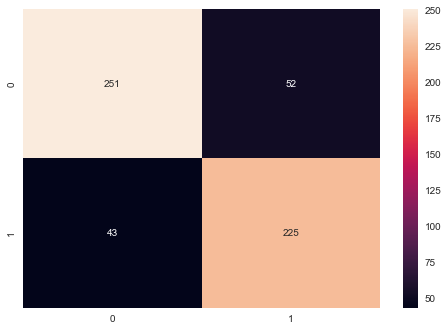

In [31]:
y_train_pred = cross_val_predict(best_knn_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

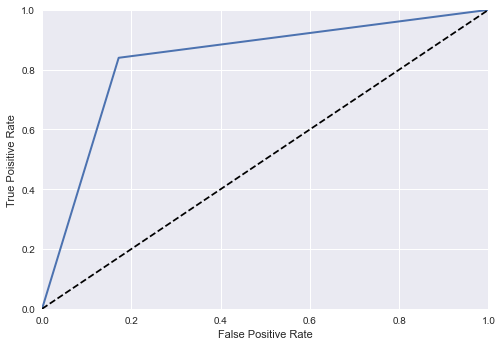

In [32]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_knn, tpr_knn, "K-Nearest Neighbors")
plt.show()

In [33]:
roc_auc_score(y_train, y_train_pred)

0.8339675385448992

# We evaluate the model with test set:

<AxesSubplot:>

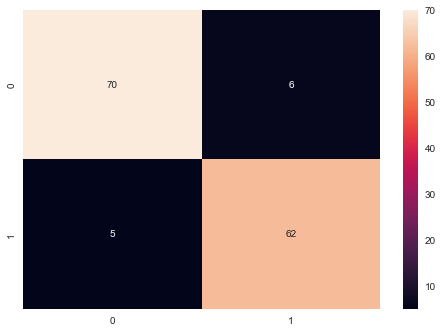

In [34]:
y_test_pred = cross_val_predict(best_knn_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

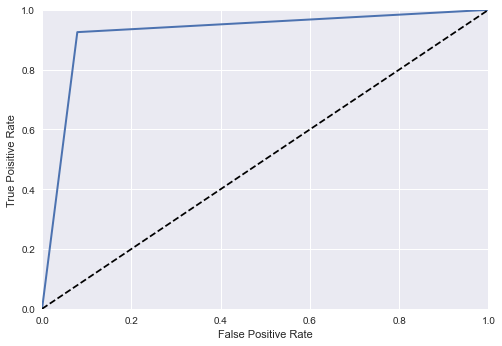

In [35]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_knn, tpr_knn, "K-Nearest Neighbors")
plt.show()

In [36]:
roc_auc_score(y_test, y_test_pred)

0.9232128829536528

# We calculate the scores

In [37]:
knn_scores = print_scores(y_test, y_test_pred)


Accuracy:92.3076923076923
Precision:91.17647058823529
Recall:92.53731343283582
F1-score:92.31071111865813


# C-Support Vector Classifier.

We train the model

In [38]:
param_grid = [{
    "C": np.linspace(1, 1.5, 10),
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "gamma": ['scale', 'auto']
}]

svc_clf = SVC()
grid_svc = GridSearchCV(svc_clf, param_grid, scoring=metric, cv=cv)
grid_svc.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=SVC(),
             param_grid=[{'C': array([1.        , 1.05555556, 1.11111111, 1.16666667, 1.22222222,
       1.27777778, 1.33333333, 1.38888889, 1.44444444, 1.5       ]),
                          'gamma': ['scale', 'auto'],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             scoring='recall')

In [39]:
best_svc_clf = grid_svc.best_estimator_
grid_svc.best_params_

{'C': 1.0, 'gamma': 'auto', 'kernel': 'sigmoid'}

<AxesSubplot:>

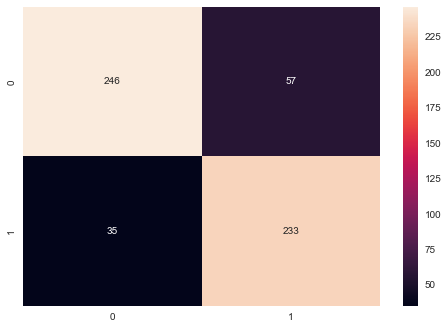

In [40]:
y_train_pred = cross_val_predict(best_svc_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

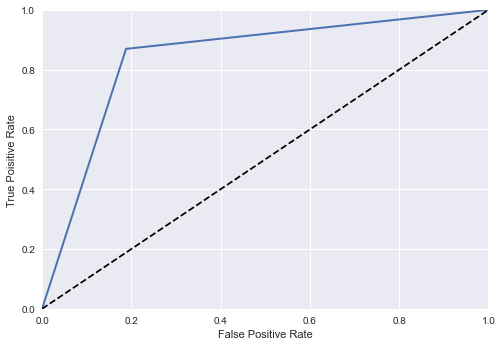

In [41]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plt.show()

In [42]:
roc_auc_score(y_train, y_train_pred)

0.8406420865967195

# We evaluate the model with test set:

<AxesSubplot:>

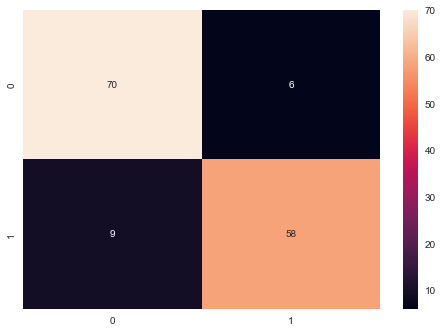

In [43]:
y_test_pred = cross_val_predict(best_svc_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

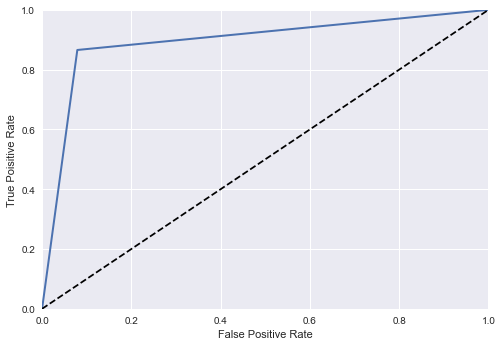

In [44]:
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")
plt.show()

In [45]:
roc_auc_score(y_test, y_test_pred)

0.893362136684996

We calculate the scores

In [46]:
svc_scores = print_scores(y_test, y_test_pred)

Accuracy:89.5104895104895
Precision:90.625
Recall:86.56716417910447
F1-score:89.49189200358863


# Random Forest Classifier

We train the model

In [47]:
nFeatures

38

In [48]:
param_grid = [{"n_estimators":[650, 700, 750, 800],
               'criterion':['gini','entropy'],
               "max_features":[nFeatures-9, nFeatures-8, nFeatures-5]
              }]
rf_clf = RandomForestClassifier(random_state=42)
grid_forest = GridSearchCV(rf_clf, param_grid, cv=cv, scoring=metric)
grid_forest.fit(X_train, y_train)

GridSearchCV(cv=15, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_features': [29, 30, 33],
                          'n_estimators': [650, 700, 750, 800]}],
             scoring='recall')

In [49]:
best_rf_clf = grid_forest.best_estimator_
best_rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 30,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

<AxesSubplot:>

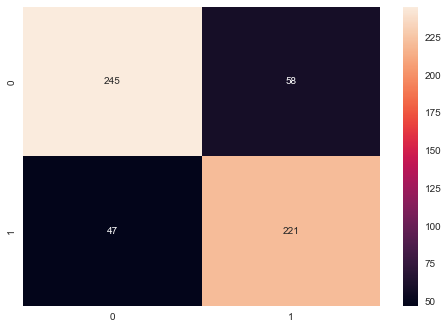

In [50]:
y_train_pred = cross_val_predict(best_rf_clf, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

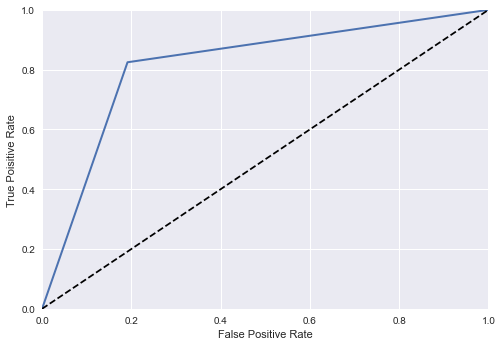

In [51]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_train_pred)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [52]:
roc_auc_score(y_train, y_train_pred)

0.8166038618787251

We evaluate the model with test set:

<AxesSubplot:>

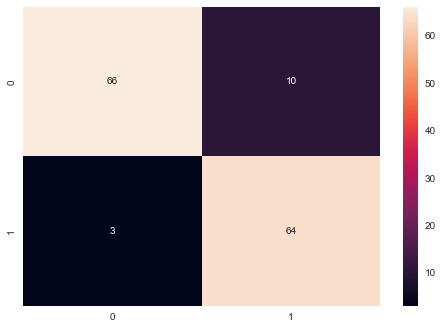

In [53]:
y_test_pred = cross_val_predict(best_rf_clf, X_test, y_test, cv=cv)
conf_mx = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_mx, annot=True, fmt='')

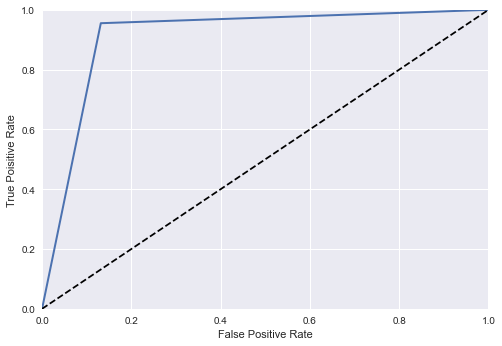

In [54]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.show()

In [55]:
roc_auc_score(y_test, y_test_pred)

0.9118224666142971

We calculate the scores

In [56]:
rf_scores = print_scores(y_test, y_test_pred)

Accuracy:90.9090909090909
Precision:86.48648648648648
Recall:95.52238805970148
F1-score:90.9153160363725


# Model Score Comparisons

In [57]:
scores = pd.DataFrame(data=[list(knn_scores.values()), list(svc_scores.values()), list(rf_scores.values())], columns=list(knn_scores.keys()))
scores = scores.transpose()
scores = scores.rename(columns={0:"K-Nearest Neighbors", 1:"C-Support Vector", 2:"Random Forest"})
scores.style.highlight_max(color = 'green', axis = 1)

,K-Nearest Neighbors,C-Support Vector,Random Forest
ac,92.307692,89.510490,90.909091
pr,91.176471,90.625000,86.486486
rc,92.537313,86.567164,95.522388
f1,92.310711,89.491892,90.915316


According to our focus the best recall score was present for the Random Forest classifier, but also this classifier present the worst precision score, we must find a balance between recall score and precision score, for me the best model is the KNN classifier